# Preamble

See the script below for all package imports

In [1]:
%run -i scripts/preamble.py

> __Note__: Due to submission size limitations, the datasets were __not__ included in the submitted zip file. Instead, I have made them publicly downloadable from S3. Please refer to the data download instructions in the README file.

# Introduction

The global digital advertising market is worth approximately \\$602 billion today. Due to the increasing rate of of online participation since the COVID-19 pandemic, this number has been rapidly increasing and is expected to reach \\$871 billion by the end of 2027 ([eMarketer, 2024](#eMarketer)). Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of Machine Learning research over the past through years.

Initially, shallow prediction methods such as Logistic Regression, Factorization Machines ([Rendel, 2010](#RendelFM)) and Field-Aware Factorization Machines ([Juan et al, 2016](#JuanFAFM)) have been used for CTR prediction. However, these methods have often been shown to be unable to capture the higher order feature interactions in the sparse multy value categorical Ad Marketplace datasets (Cite). Since then, Deep Learning methods have been shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep Learning architechtures for click-through rate prediction.

In the following report, I explore the relevant datasets and simulations that I will be using throughout my research project. [In the first section](#data-analysis-and-pre-processing), I perform an exploratory data analysis on three widely adopted benchmark CTR prediction datasets; the KDD12 ([Aden, 2012](#kdd12)), Avazu ([Wang and Cukierski, 2014](#avazu)) and Criteo ([Tien et al, 2014](#criteo)) datasets. [In the second section](#modelling), I then compare the relative performance of Logistic Regression, Factorization Machines and a simple Mult-Layer Perceptron DNN model for predicting the Click through rate, in order to assess the feasibilty of using this data for CTR prediction.

# Data Analysis and Pre-processing

I begin below by first introducting the three datasets widely used as benchmarks in CTR prediction research.

### KDD12

The __KDD12__ dataset was first released for the KDD Cup 2012 competition ([Aden, 2012](#kdd12)), with the original task being to predict the number of clicks for a given number of impressions. Each line represents a training instance derived from the session logs for the advertizing marketplace. In the context of this dataset, a "session" refers to an interaction between a user and the search engine, containing the following components; the user, a list of adverts returned by the search engine and shown (impressed) to the user and zero or more adverts clicked on by the user. Each line in the training set includes, Click and Impression counts, Session features, User features and Ad features.

In [2]:
%run -i scripts/data_analysis_and_preprocessing/retrieve_kdd12.py

Snapshot of KDD12 training data:


,Click,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID
0,0,1,12057878999086460853,20157098,27961,1,1,75606,15055,12391,13532,1350148
1,0,1,12057878999086460853,20221208,27961,2,1,2977,1278,3054,4561,1350148


### Avazu

The __Avazu__ dataset was originally released in 2014 for a CTR prediction Competition on Kaggle ([Wang and Cukierski, 2014](#avazu)). The data is composed of 11 days worth mobile ad marketplace data. Much like the KDD12 dataset above, this dataset contains features ranging from user activity (clicks), user identification (device type, IP) to ad features. Notible differences to the KDD12 dataset include the fact that Avazu contains an "hour" feature (enabling the establishment of sequentiality of behaviours) and the fact that Avazu does not seem to contain query and ad texts.

In [3]:
%run -i scripts/data_analysis_and_preprocessing/retrieve_avazu.py

Snapshot of Avazu training data:


,id,click,hour,c1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,c14,c15,c16,c17,c18,c19,c20,c21
0,15674134821169810910,1,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,e71aba61,2347f47a,...,1,0,21676,320,50,2495,2,167,-1,23
1,15674278914362889244,0,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,6f8bcb0f,2347f47a,...,1,0,20476,320,50,2348,3,427,100005,61


### Criteo

Finally, the Criteo dataset is another benchmark CTR prediction dataset that was originally released on Kaggle for a CTR prediction compitition. The original dataset is made up of 45 Million user's click activity, and contains the click/no-click target along with 26 categorical feature fields and 13 numerical feature fields. Unlike the other two datasets however, the semintic significance of these fields is not given - they are simply labelled as "Categorical 1-26" and "Numerical 1-13" respectively.

In [4]:
%run -i scripts/data_analysis_and_preprocessing/retrieve_criteo.py

Snapshot of Criteo training data:


,click,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,...,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,cat_24,cat_25,cat_26
0,0,NaN,1,2.0,5.0,27586.0,32.0,2.0,14.0,21.0,...,07c540c4,bdc06043,NaN,NaN,6dfd157c,NaN,32c7478e,ef089725,NaN,NaN
1,1,14.0,1,1.0,8.0,276.0,14.0,41.0,9.0,10.0,...,e5ba7672,87c6f83c,NaN,NaN,0429f84b,NaN,be7c41b4,c0d61a5c,NaN,NaN


### Missingness and Data Imputation

From the first few rows of the Criteo dataset above, we can already see that a few of the values are already missing. I have constructed a missingness matrix with the help of the `missningno` python package, [which I have made avalable on Github](https://github.com/martinbatek/mlds_final_project_milestone2/blob/main/figures/criteo_missingno_matrix.png). The matrix reveals all of the records sampled have at least 1 null feature value (in fact, from the chart on the right we can see that the minimum NA count in the dataset is 17 values per record.)

Below I proceed by imputing the missing values using Sklearn's KNN Imputer. The code for these imputations does not get executed here due to CPU and memory constraints. Imputation steps taken were:

1. Factorize categorical values in the dataset, converting them to integers. This was done because sklearn's imputers only work with numerical data.
2. Use the sklearn's [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) with [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) to impute the missing values. This was recommended in [this github discussion](https://github.com/scikit-learn/scikit-learn/discussions/28545) for imputing data with categorical values.
3. Concatinate missingness indicators to the dataset as additional features, as recommended by [Van Buuren (2018)](#vanBuuren)

The script for the above is in [scripts/data_analysis_and_processing/impute_criteo_nulls.py](https://github.com/martinbatek/mlds_final_project_milestone2/blob/main/scripts/data_analysis_and_preprocessing/impute_criteo_nulls.py).

In [5]:
# Pick up the imputed dataset
criteo_imputed_inds = pd.read_csv('./data/criteo/criteo_train_imputed.csv').astype('int')
criteo_imputed_inds[criteo.columns[criteo.dtypes == 'category']] = criteo_imputed_inds[criteo.columns[criteo.dtypes == 'category']].clip(lower=0,upper=None)

### Sparse Multi-Value Categorical Features

As already mentioned above, ad marketplace data often contains sparse categorical features, which make signal detection extremely difficult in shallow modelling frameworks. Below I show examples from each dataset

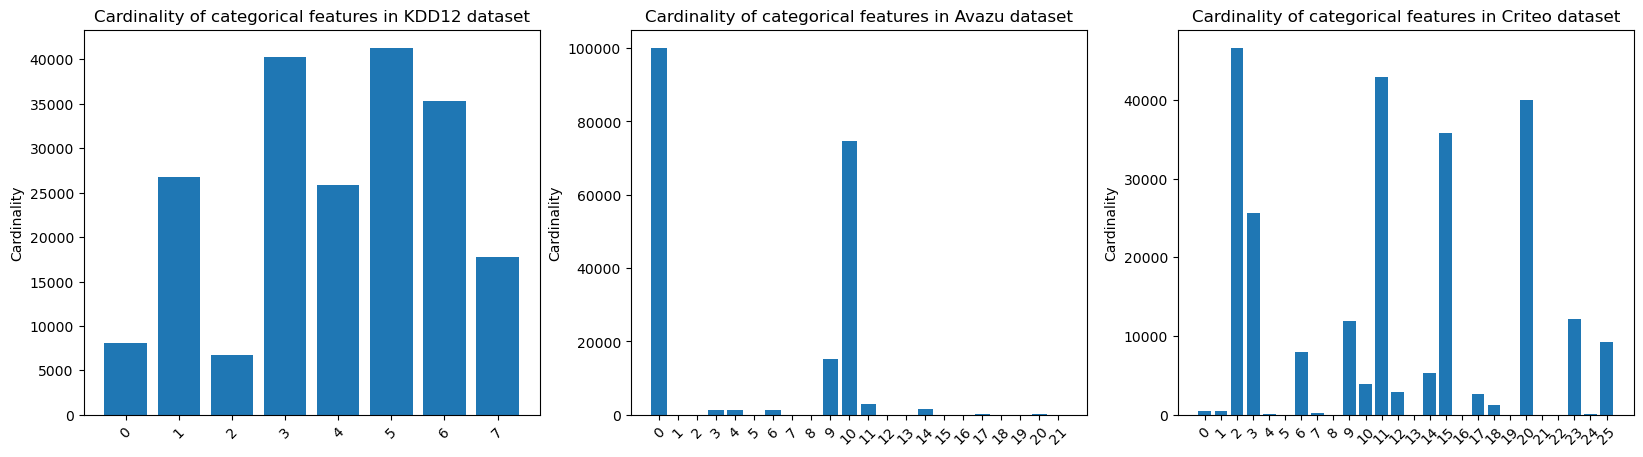

In [6]:
%run -i scripts/data_analysis_and_preprocessing/plot_cardinalities.py

A common remidy to the above issue is to _bin_ the categorical feature values before one-hot encoding or embedding, according to some given threshold (Cite Song, Others). This essentially means that for a given threshold $t$, we retain only the values for the multi-value categorical features that have more than $t$ occurances in the dataset. (Cite Song) Reccomends usign, setting $t = {10,5,10}$ for Criteo, KDD12 and Avazu respectively. Due to computational limitations, this was multiplied by a factor of 100

In [7]:
%run -i scripts/data_analysis_and_preprocessing/binned_OH_encoding.py

Before one-hot encoding:
KDD12 shape: (100000, 12)
Avazu shape: (100000, 24)
Criteo shape: (100000, 64)

After one-hot encoding:
KDD12 shape: (100000, 12)
Avazu shape: (100000, 24)
Criteo shape: (100000, 64)
Sparse output:
KDD12 shape: (100000, 1478)
Avazu shape: (100000, 924)
Criteo shape: (100000, 2003)


### High Variance Numerical outliers

Below I check the distributions of the numerical features in the datasets. We see that the variance for some of the numerical features in the Criteo dataset are relatively high.

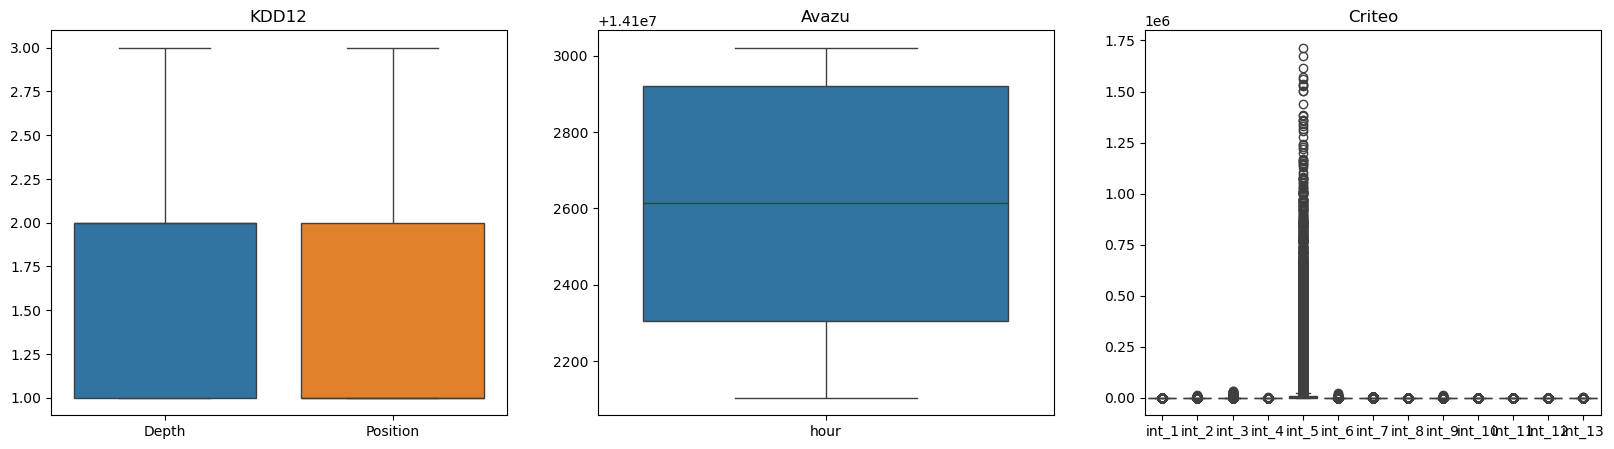

In [8]:
%run -i scripts/data_analysis_and_preprocessing/plot_numerical_distributions.py

Due to the high variance of numerical features in the Criteo dataset, it is necessary to transform these variable in order to ease the training of deep NN's. As done be ([Song et al (2019)](#Song) and [Wang et al (2023)](#Wang)), we will proceed by applying the transform $\log^2 (z)$ if $z>2$, and where $z$ is the standardized numerical value.

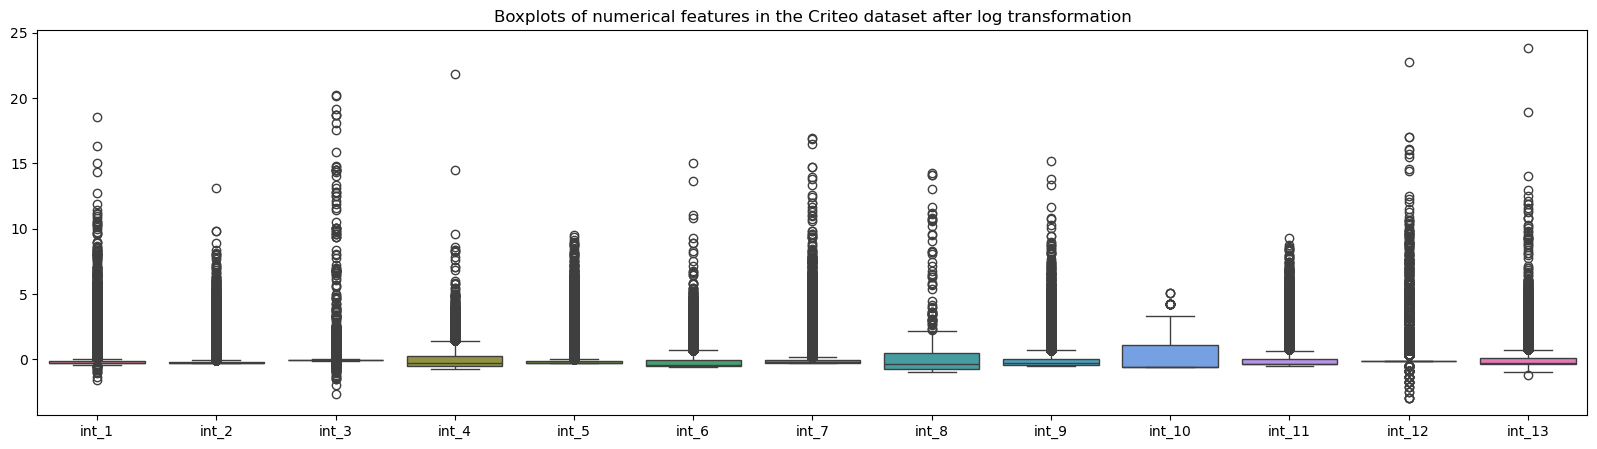

In [9]:
%run -i scripts/data_analysis_and_preprocessing/numerical_standardization.py
%run -i scripts/data_analysis_and_preprocessing/export_preprocessed.py

### Correlation Analysis

In the [following script](https://github.com/martinbatek/mlds_final_project_milestone2/blob/main/scripts/data_analysis_and_preprocessing/correlation_analysis.py), conduct a correlation analysis of the features to the Click-Through rate. The results are avalable on Github for the [KDD12](https://github.com/martinbatek/mlds_final_project_milestone2/blob/main/figures/kdd12_corr_matrix.png), [Criteo](https://github.com/martinbatek/mlds_final_project_milestone2/blob/main/figures/criteo_corr_matrix.png), and [Avazu](https://github.com/martinbatek/mlds_final_project_milestone2/blob/main/figures/avazu_corr_matrix.png) datasets. The heatmaps only show features where at least one non-diagonal correlation had an absolute value higher than 0.9.

There are some very high correlations between some of the features across fields in all three datasets. This possibly points to there being potential for dimensionality reduction across this feature set. Unfortunately, from the correlation heatmaps, there appears to be little to no correlation between the first-order features and the target click variable.

# Modelling

In this section I will compare the perfomance of two shallow modelling approaches (Logistic Regression and Factorization Machines) to a naive DNN for CTR prediction. As with ([Song et al (2019)](#Song) and [Wang et al (2023)](#Wang)), I will use the __Area Under the ROC Curve__ and __Logloss__ measures to compare the performance of the different modelling approaches on the test set.

In [10]:
%run -i scripts/modelling/load_and_prep_data.py

## Logistic Regression

The script below implements a simple [Logistic Regression model from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), keeping the default parameters.

In [11]:
%run -i scripts/modelling/fit_lr_models.py
%run -i scripts/modelling/score_lr_models.py
%run -i scripts/modelling/save_lr_models.py

KDD12:
Log loss: 0.162493229115702
ROC AUC: 0.69918173566772
Accuracy: 0.95825

Avazu:
Log loss: 0.41220123857803254
ROC AUC: 0.7187724509322894
Accuracy: 0.83205

Criteo:
Log loss: 0.4934802653385648
ROC AUC: 0.7450124095275693
Accuracy: 0.7671


## Factorization Machine

Below I proceed by applying the SGD solver, as shown in the [relevant tutorial](https://ibayer.github.io/fastFM/tutorial.html#logit-classification-with-sgd-solver) for FastFM ([Bayer, 2016](#FastFM)).

>__Note__: Unfortunately, the fastFM library is currently only compatible with Linux and iOS. Since I have a Windows PC, I ran the training script below on an AWS Sagemaker Instance.

In [12]:
%run -i scripts/modelling/fit_fm_models.py
%run -i scripts/modelling/score_fm_models.py
%run -i scripts/modelling/save_fm_models.py

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 15.774504905747122
ROC AUC: 0.47794380839584155
Accuracy: 0.56235


## MLP
In this section, I implement a simple 3 layer MLP for CTR prediction. This is a MLP containing 3 Dense layers with ReLu activation and 128, 64 and 32 neurons, each followed by BatchNormalization and DropOut layers. The output layer is a single Dense layer with Sigmoid activation.

2024-06-28 11:02:23.734417: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-28 11:02:23.737401: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 11:02:23.739680: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-06-28 11:02:32.431741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-28 11:02:32.460960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               189056    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

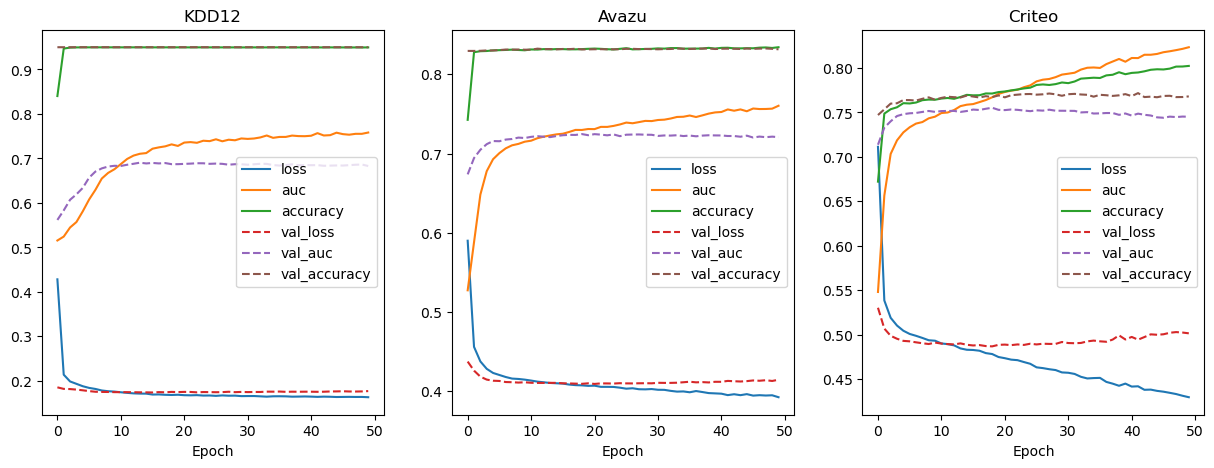

In [13]:
%run -i scripts/modelling/load_tf_datasets.py
%run -i scripts/modelling/fit_kdd12_mlp.py
%run -i scripts/modelling/fit_avazu_mlp.py
%run -i scripts/modelling/fit_criteo_mlp.py
%run -i scripts/modelling/plot_mlp_training.py

In [14]:
%run -i scripts/modelling/eval_mlp_models.py

AttributeError: 'str' object has no attribute 'decode'

# Summary of findings and Further Research

Much of the work done in advance of this assignment has been focussed on establishing data processing poplines. The datasets used in this analysis are 100K subsamples of the original datasets, which tend to be excessivly large (the full Criteo dataset is 1TB). As cited here and in my Milestone 1 presentation, the key challenge of CTR prediction stems from the fact that the majority of the features are typically multi-value categoricals with high cardinality, resulting in high sparsity.

In the preprocessing section, we saw that a common approch to ensure that any model fitting task is feasible in this context, most pre-processing of CTR data involves "binning" the categorical feature values to some minimum data frequency threshold. Models such as FM and DeepFM then focus on capturing the feature interactions that are the most informative to the CTR preduction. However, contrary to this, in the modelling section we say that a simple Logistic Regression Model performed comparitively well to a simple MLP, and better than FM.

My next area of focus will be on reviewing and exploring some of the Deep Learning CTR prediction models, such as [DeepFM](#DeepFM) and [AutoInt](#Song). Once this is done, I will turn to formulating a method for simulating the data generating process for the datasets explored, in order to be able to test and implement a Reinforecement Learning framework for Ad persionalization using a Deep CTR model.

<a class="anchor" id="references"></a>

# References

<a class="anchor" id="eMarketer"></a>

- eMarketer. (2023). Digital advertising spending worldwide from 2021 to 2027 (in billion U.S. dollars) . Statista. Statista Inc.. Accessed: June 09, 2024. https://www-statista-com.iclibezp1.cc.ic.ac.uk/statistics/237974/online-advertising-spending-worldwide/

<a class="anchor" id="kdd12"></a>

- Aden, Yi Wang. (2012). KDD Cup 2012, Track 2. Kaggle. https://kaggle.com/competitions/kddcup2012-track2

<a class="anchor" id="avazu"></a>

- Steve Wang, Will Cukierski. (2014). Click-Through Rate Prediction. Kaggle. https://kaggle.com/competitions/avazu-ctr-prediction

<a class="anchor" id="criteo"></a>

- Jean-Baptiste Tien, joycenv, Olivier Chapelle. (2014). Display Advertising Challenge. Kaggle. https://kaggle.com/competitions/criteo-display-ad-challenge

<a class="anchor" id="vanBuuren"></a>

- Van Buuren, S. (2018). Flexible imputation of missing data. CRC press.

<a class="anchor" id="Song"></a>

- Song, W., Shi, C., Xiao, Z., Duan, Z., Xu, Y., Zhang, M., & Tang, J. (2019, November). Autoint: Automatic feature interaction learning via self-attentive neural networks. In Proceedings of the 28th ACM international conference on information and knowledge management (pp. 1161-1170).

<a class="anchor" id="Wang"></a>

- Wang, F., Gu, H., Li, D., Lu, T., Zhang, P., & Gu, N. (2023, October). Towards Deeper, Lighter and Interpretable Cross Network for CTR Prediction. In Proceedings of the 32nd ACM International Conference on Information and Knowledge Management (pp. 2523-2533).

<a class="anchor" id="RendelFM"></a>

- Rendle, S. "Factorization Machines," 2010 IEEE International Conference on Data Mining, Sydney, NSW, Australia, 2010, pp. 995-1000, doi: 10.1109/ICDM.2010.127.

<a class="anchor" id="JuanFAFM"></a>

- Yuchin Juan, Yong Zhuang, Wei-Sheng Chin, and Chih-Jen Lin. 2016. Field-aware Factorization Machines for CTR Prediction. In Proceedings of the 10th ACM Conference on Recommender Systems (RecSys '16). Association for Computing Machinery, New York, NY, USA, 43–50. https://doi.org/10.1145/2959100.2959134

<a class="anchor" id="DeepFM"></a>

- Guo, H., Tang, R., Ye, Y., Li, Z., & He, X. (2017). DeepFM: a factorization-machine based neural network for CTR prediction. arXiv preprint arXiv:1703.04247.

<a class="anchor" id="FastFM"></a>

- Bayer, I. (2016). fastfm: A library for factorization machines. Journal of Machine Learning Research, 17(184), 1-5.